<h3 style='text-align: right;'> Geophysics Independent Project </h3>

## Notebook 6: Saving and merging seismograms

Now that you can download and process seismograms, you may want to analyse data over many days.  In this case, you'll probably want to consider the data in pieces. But that means you'll have to save the pieces and reload them later.  You already know how to load pieces of a seismogram from a file (see notebook 1).  So in this notebook, you'll learn to (1) save seismograms, (2) merge seismograms, and (3) deal with some issues that arise in merging.

In [7]:
import numpy as np 
import obspy
import matplotlib.pyplot as plt
import os,glob

Note that this time we've imported two more packages: os and glob.  These will allow us to save and access files.

### 1.  Dowload, process, and save seismograms

To start, let's just try retrieving few-minute intervals of a seismogram, saving those intervals, and recovering them later.

#### 1.1 Choose data to analyse

For now, I'll pick the same station as I considered in seismic amplitude analysis: near Swindon.  And altogether I'll just look at a half hour of data.  

_Q1: Change the code below to choose a half-hour or hour-long interval at a station you're interested in._

In [8]:
# I've picked a station near Swindon run by the BGS
station='SWN1'
network='GB'

# and I'll pick the 100-Hz rather than the 50-Hz data, as I might be interested in high-frequency signals
channels='HH?'

# let's choose a Tuesday afternoon in November
ttot_1 = obspy.UTCDateTime(2023,11,13,14,0,0)

# half an hour from 14:00 UTC
# NB: if everything is running very slowly, just try a shorter interval
ttot_2 = ttot_1 + 1800

In [9]:
# let's divide this half-hour time period into <5-minute intervals

# starts of the intervals
tstart=np.arange(ttot_1,ttot_2-299,300)

# ends of the intervals
tstop=tstart+300

print('Here are the interval start times: ',tstart)

print('\nThe first interval goes from ',tstart[0],' to ',tstop[0])

Here are the interval start times:  [UTCDateTime(2023, 11, 13, 14, 0) UTCDateTime(2023, 11, 13, 14, 5)
 UTCDateTime(2023, 11, 13, 14, 10) UTCDateTime(2023, 11, 13, 14, 15)
 UTCDateTime(2023, 11, 13, 14, 20) UTCDateTime(2023, 11, 13, 14, 25)]

The first interval goes from  2023-11-13T14:00:00.000000Z  to  2023-11-13T14:05:00.000000Z


#### 1.2 Download and process the first interval

Let's download the first interval and remove the instrumental response.

In [10]:
# note the start and end times
t1=tstart[0]
t2=tstop[0]

print('Want to analyse data from ',t1,' to ',t2)

# remember to buffer the time interval to download, as we'll want to discard the beginning and the end 
t1_grab=t1-300
t2_grab=t2+300

print('But we will download data from ',t1_grab,' to ',t2_grab)


Want to analyse data from  2023-11-13T14:00:00.000000Z  to  2023-11-13T14:05:00.000000Z
But we will download data from  2023-11-13T13:55:00.000000Z  to  2023-11-13T14:10:00.000000Z


In [12]:
# open a connection to the data server 
from obspy.clients.fdsn.client import Client
client = Client("IRIS")

# and download the data, remembering to ask for the response information
# download the data
st = client.get_waveforms(network=network,station=station,location="*",channel=channels, 
                            starttime=t1_grab,endtime=t2_grab,attach_response=True)

_Q2: Check that you got the data you expected._

In [13]:
# your code here

In [14]:
st[0].stats

               network: GB
               station: SWN1
              location: 
               channel: HHE
             starttime: 2023-11-13T13:55:00.000000Z
               endtime: 2023-11-13T14:10:00.000000Z
         sampling_rate: 100.0
                 delta: 0.01
                  npts: 90001
                 calib: 1.0
_fdsnws_dataselect_url: http://service.iris.edu/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'M', 'number_of_records': 303, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 466944})
            processing: ['ObsPy 1.4.1: trim(endtime=UTCDateTime(2023, 11, 13, 14, 10)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2023, 11, 13, 13, 55))']
              response: Channel Response
	From m/s (VELOCITY IN METERS PER SECOND) to counts (DIGITAL COUNTS)
	Overall Sensitivity: 6.12572e+08 defined at 1.000 Hz
	2 stages:
		Stage 1: PolesZerosResponseStage from m/s

In [15]:
# now we can correct for the instrument response
# this pre-filter says we'll ignore periods longer than 50 s
st.remove_response(output='VEL',pre_filt=[0.01,0.02,float('inf'),float('inf')]);

In [16]:
# and trim to the time interval I wanted in the first place
st.trim(starttime=t1,endtime=t2)

3 Trace(s) in Stream:
GB.SWN1..HHE | 2023-11-13T14:00:00.000000Z - 2023-11-13T14:05:00.000000Z | 100.0 Hz, 30001 samples
GB.SWN1..HHN | 2023-11-13T14:00:00.000000Z - 2023-11-13T14:05:00.000000Z | 100.0 Hz, 30001 samples
GB.SWN1..HHZ | 2023-11-13T14:00:00.000000Z - 2023-11-13T14:05:00.000000Z | 100.0 Hz, 30001 samples

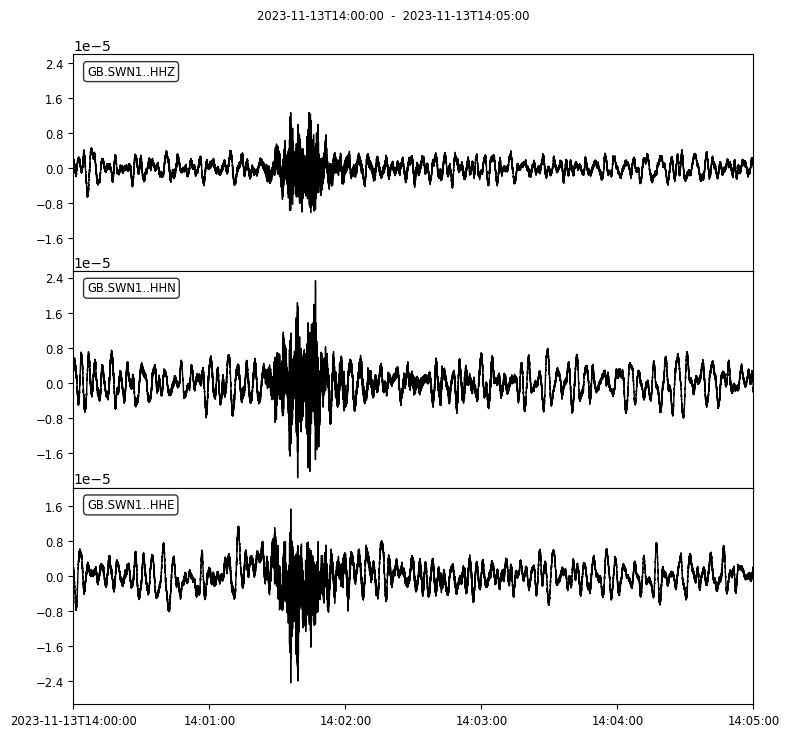

In [17]:
# plot to see what the data look like
st.plot();

#### 1.3 Save the seismogram from the first interval

Let's imagine we want to use this seismogram again later and don't want to retrieve it from IRIS or ORFEUS again.  We should save it to disk.  

Managing data can be a major challenge in seismology and many other fields, so let's start well.  Create a directory (aka folder) to store this set of seismograms and name it 'First_Seismogram_Set'.  

We now have to tell Python which directory we want.  The format of the directory name will vary depending on your operating system.  A few examples are below.

In [20]:
# on Mac or Linux, specifying the full path
# this directory 
directory = '/home/seismology_project/First_Seismogram_Set'

# on Windows
directory = r'C:\Users\jhawt\Documents\FILES\PYFILES\IndependentProjects'

# on any system, if you've navigated to the directory of interest
# this just says we want the current working directory, with 'First_Seismogram_Set' on the end
directory = os.path.join('.','First_Seismogram_Set')

In [21]:
# we can use a function from the package os (short for 'operating system')
# to check that this directory exists
print('My seismograms will be in directory ',directory)

print('\nDoes this directory exist?')
print(os.path.exists(directory))

My seismograms will be in directory  .\First_Seismogram_Set

Does this directory exist?
True


_Q3. Create your directory and modify the code above to check that you can access it._

In [22]:
# let's call the first file 'seismograms_0.mseed'
# we need to tell Python the full file name: to combine the directory name with 'seismograms_0.SAC'
fname=os.path.join(directory,'seismograms_0.MSEED')
print(fname)

.\First_Seismogram_Set\seismograms_0.MSEED


In [23]:
# and now we can just save the seismograms
# don't worry if you get an encoding warning---it's probably fine.  
# just check that everything's okay when you re-read the files
st.write(fname)

C:\Users\jhawt\PROGRAMS\miniconda3\envs\secondyearprojects\Lib\site-packages\obspy\io\mseed\core.py:773: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


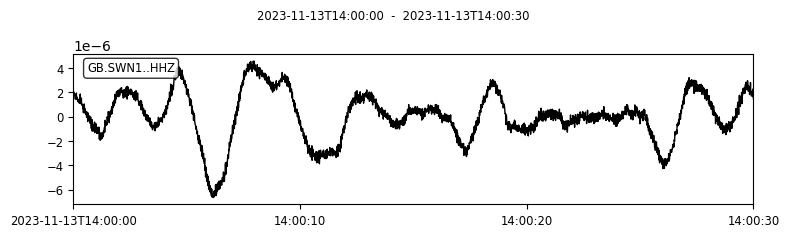

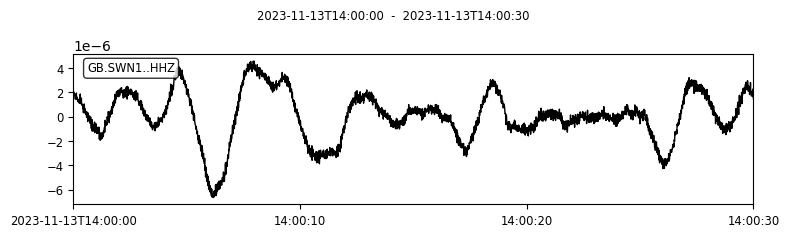

In [24]:
# let's re-read the file to check it looks the same as what we've saved
st2=obspy.read(fname)

# plot the original and recovered data
st.select(channel='HHZ')[0].plot(starttime=t1,endtime=t1+30);
st2.select(channel='HHZ')[0].plot(starttime=t1,endtime=t1+30);

_Q4: Save the data from your first trace and checked that everything worked as expected._

_Q5: How sensible do your seismograms look?  Are there any odd features you might have introduced?  If so, how and when might you correct them?_

Your answer here.

#### 1.4 Process and save data from all intervals

Now we can consider each interval in turn.  We download, remove the instrument response, and save.

In [25]:
# loop through with a for loop
for k in range(0,len(tstart)):
    
    # for each interval, grab the start and end time
    t1=tstart[k]
    t2=tstop[k]
    
    # buffer
    t1_grab=t1-300
    t2_grab=t2+300
    
    # download the data
    st = client.get_waveforms(network=network,station=station,location="*",channel=channels, 
                            starttime=t1_grab,endtime=t2_grab,attach_response=True)
    
    # remove the instrument response
    st.remove_response(output='VEL',pre_filt=[0.01,0.02,float('inf'),float('inf')]);
    
    # trim to desired time
    # I've added 0.1 seconds to the end time here 
    # so that the saved seismograms overlap a bit
    st.trim(starttime=t1,endtime=t2+0.1)
     
    # let's name the kth seismogram 'seismogram_k.MSEED'
    filename='seismograms_{:d}.MSEED'.format(k)
    
    # and the full file name adds the directory
    fullname=os.path.join(directory,filename)
    print('Saving the {:d}th seismogram to file {:s}'.format(k,fullname))
    
    # save
    st.write(fullname)
    

Saving the 0th seismogram to file .\First_Seismogram_Set\seismograms_0.MSEED


C:\Users\jhawt\PROGRAMS\miniconda3\envs\secondyearprojects\Lib\site-packages\obspy\io\mseed\core.py:773: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Saving the 1th seismogram to file .\First_Seismogram_Set\seismograms_1.MSEED


C:\Users\jhawt\PROGRAMS\miniconda3\envs\secondyearprojects\Lib\site-packages\obspy\io\mseed\core.py:773: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Saving the 2th seismogram to file .\First_Seismogram_Set\seismograms_2.MSEED


C:\Users\jhawt\PROGRAMS\miniconda3\envs\secondyearprojects\Lib\site-packages\obspy\io\mseed\core.py:773: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Saving the 3th seismogram to file .\First_Seismogram_Set\seismograms_3.MSEED


C:\Users\jhawt\PROGRAMS\miniconda3\envs\secondyearprojects\Lib\site-packages\obspy\io\mseed\core.py:773: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Saving the 4th seismogram to file .\First_Seismogram_Set\seismograms_4.MSEED


C:\Users\jhawt\PROGRAMS\miniconda3\envs\secondyearprojects\Lib\site-packages\obspy\io\mseed\core.py:773: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Saving the 5th seismogram to file .\First_Seismogram_Set\seismograms_5.MSEED


C:\Users\jhawt\PROGRAMS\miniconda3\envs\secondyearprojects\Lib\site-packages\obspy\io\mseed\core.py:773: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)




### 2. Read and merge the seismograms

Now that you've written all the seismograms to a file, let's see if you can reload and merge them.



In [26]:
# we'll want to read all the seismograms that have a particular name format
# directory/seismograms_*.MSEED
fformat = os.path.join(directory,'seismograms_*.MSEED')

# we can use the package glob to see what files are available
print('Files with format matching {:s}:'.format(fformat))
fls=glob.glob(fformat)
print(fls)

# but obspy.read can all search for matching files on the fly
st=obspy.read(fformat)


Files with format matching .\First_Seismogram_Set\seismograms_*.MSEED:
['.\\First_Seismogram_Set\\seismograms_0.MSEED', '.\\First_Seismogram_Set\\seismograms_1.MSEED', '.\\First_Seismogram_Set\\seismograms_2.MSEED', '.\\First_Seismogram_Set\\seismograms_3.MSEED', '.\\First_Seismogram_Set\\seismograms_4.MSEED', '.\\First_Seismogram_Set\\seismograms_5.MSEED']


_Q6: Read in all your saved seismograms.  How many traces are there in the stream? Do they match the time intervals you expect?_

Your answer here.

You'll likely have found that when you read in your seismogram, you have lots of traces: one per 5-minute interval per channel.  But that's a bit silly.  You likely have 30 minutes of continuous seismogram---we'd like one trace per channel.  So let's merge them.

In [27]:
st.merge(method=1);

In [29]:
st

3 Trace(s) in Stream:
GB.SWN1..HHE | 2023-11-13T14:00:00.000000Z - 2023-11-13T14:30:00.100000Z | 100.0 Hz, 180011 samples
GB.SWN1..HHN | 2023-11-13T14:00:00.000000Z - 2023-11-13T14:30:00.100000Z | 100.0 Hz, 180011 samples
GB.SWN1..HHZ | 2023-11-13T14:00:00.000000Z - 2023-11-13T14:30:00.100000Z | 100.0 Hz, 180011 samples

Your answer here.

_Q8: If everything has gone well, your reloaded data should look just the same as if you directly downloaded and processed 30 minutes of data from IRIS or ORFEUS.  Try that.  Compare the seismograms you get if you download, save, and reload 5 minutes of data at a time with the seismograms you get if you download and process 30 minutes of data._ 

In [19]:
# your code here

### 3. Troubleshooting missing data

Saving and merging seismograms is straightforward when the seismograms overlap a bit; when there are no missing pieces.  But of course there are gaps in seismic records. Stations fail and have to be restarted.  Or maybe there was a large earthquake that contaminates your traffic record, and you have to discard that time interval.

#### 3.1 Simple merging with gaps

Let's compare what we have if we merge the first two five-minute intervals (a) normally and (b) after discarding 20 seconds at the end of the first five minutes. 

In [30]:
# read the seismograms
st1=obspy.read(os.path.join(directory,'seismograms_0.MSEED'))
st2=obspy.read(os.path.join(directory,'seismograms_1.MSEED'))

# try shortening the first one
st1_short=st1.copy()
st1_short.trim(starttime=st1[0].stats.starttime,endtime=st1[0].stats.endtime-10)

3 Trace(s) in Stream:
GB.SWN1..HHE | 2023-11-13T14:00:00.000000Z - 2023-11-13T14:04:50.100000Z | 100.0 Hz, 29011 samples
GB.SWN1..HHN | 2023-11-13T14:00:00.000000Z - 2023-11-13T14:04:50.100000Z | 100.0 Hz, 29011 samples
GB.SWN1..HHZ | 2023-11-13T14:00:00.000000Z - 2023-11-13T14:04:50.100000Z | 100.0 Hz, 29011 samples

In [31]:
# merge with no gaps
stm = st1+st2
stm.merge(method=1)

# merge with gaps
stmg = st1_short+st2
stmg.merge(method=1,fill_value=None)

print('With all the data:')
print(stm)

print('\nWith gaps:')
print(stmg)

With all the data:
3 Trace(s) in Stream:
GB.SWN1..HHE | 2023-11-13T14:00:00.000000Z - 2023-11-13T14:10:00.100000Z | 100.0 Hz, 60011 samples
GB.SWN1..HHN | 2023-11-13T14:00:00.000000Z - 2023-11-13T14:10:00.100000Z | 100.0 Hz, 60011 samples
GB.SWN1..HHZ | 2023-11-13T14:00:00.000000Z - 2023-11-13T14:10:00.100000Z | 100.0 Hz, 60011 samples

With gaps:
3 Trace(s) in Stream:
GB.SWN1..HHE | 2023-11-13T14:00:00.000000Z - 2023-11-13T14:10:00.100000Z | 100.0 Hz, 60011 samples (masked)
GB.SWN1..HHN | 2023-11-13T14:00:00.000000Z - 2023-11-13T14:10:00.100000Z | 100.0 Hz, 60011 samples (masked)
GB.SWN1..HHZ | 2023-11-13T14:00:00.000000Z - 2023-11-13T14:10:00.100000Z | 100.0 Hz, 60011 samples (masked)


You'll note that the merged stream is noted as having 'masked' samples.  That means that obspy has created continuous time series here but noted that some of the values are 'masked'; they contain no useful data.

_Q9. Plot the data during a 1-minute time interval centred at the boundary between the two loaded seismograms (between st1 and st2).  What happens near the boundary?_

In [32]:
# your code here

#### 4.2 Filtering with gaps

Merging seismic traces with gaps thus seems straightforward.  But what if you now want to filter the data?  Try bandpass filtering each of the merged traces (stm and stmg) to focus on frequencies between 1 and 10 Hz.

_Q10. What happens when you try to filter a trace with gaps?_

In [33]:
# your code here

Standard filtering algorithms don't work when there are gaps in the data. We could use more sophisticated filtering techniques.  However, those are computationally intensive and  don't add much.  (After all, there is no data to work with.)  

So instead, we'll (1) interpolate the data to make it continuous, (2) filter the now-continuous data, and (3) add back the mask to discard the interpolated value.

You can use some codes from our group to do this.

In [34]:
# the codes are located in a file/package called masked_filter.py
# make sure this file is in your path and import it
import masked_filter

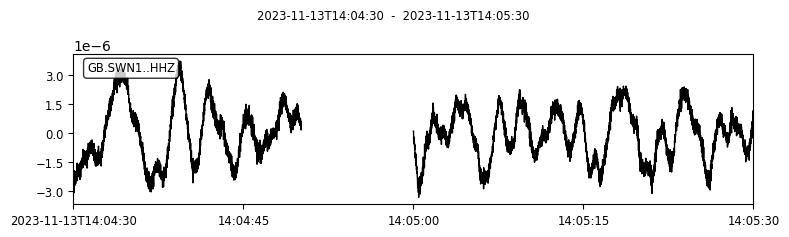

In [35]:
# we start with a trace with gaps
tmid=st2[0].stats.starttime
stmg.select(channel='HHZ').plot(starttime=tmid-30,endtime=tmid+30);

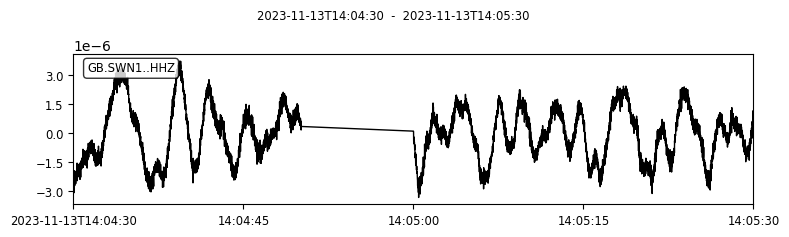

In [38]:
# now let's interpolate the data 
# the times with masked data are noted in msk
msk=masked_filter.interp_masked(stmg,tmask=10.)

# we'll also decide to mask any points in the seismogram within 10 seconds of the masked data
# that number is specified by tmask

stmg.select(channel='HHZ').plot(starttime=tmid-30,endtime=tmid+30);

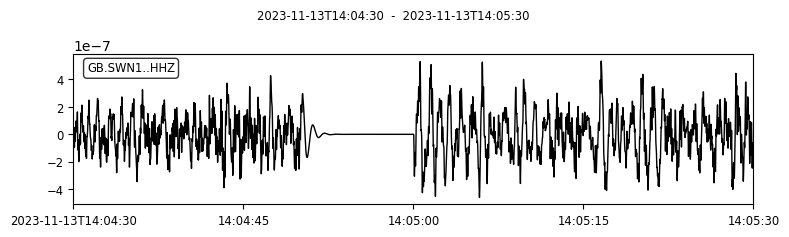

In [39]:
# now we can filter as usual
stmg.filter('bandpass',freqmin=1,freqmax=10)

# plot
stmg.select(channel='HHZ').plot(starttime=tmid-30,endtime=tmid+30);

There will likely be edge effects here.  Hopefully we'll mask out those intervals later.

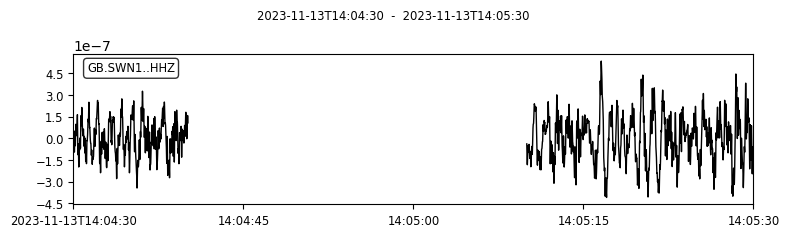

In [40]:
# and put the mask back on to discard interpolated values
masked_filter.add_mask(stmg,msk)

# plot
stmg.select(channel='HHZ').plot(starttime=tmid-30,endtime=tmid+30);